In [9]:
import sys
sys.path.insert(0, sys.path[0]+"/../")

import ENV
import BLSTM_ATT
from Step1_offlineDRL.offline_DRL.DQN import DQN
from Step1_offlineDRL.offline_DRL.PPO import PPO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Off-line DRL

In [10]:
data = pd.read_csv('../Step1_offlineDRL/DATA/rdata.csv').iloc[:,1:]
index = np.load('../Step1_offlineDRL/DATA/index.npy',allow_pickle=True).tolist()
action_table = np.load('../Step1_offlineDRL/DATA/action_table1.npy',allow_pickle=True).tolist()

agent_params={
    'state_dim':len(index['state']),
    'action_dim':len(action_table),

    'encoding_layer':[50,50],
    'value_layer':[50,50],
    'advantage_layer':[50,50],
    'test_num':144, # see pretrain_data

    'train_iterations':2,
    'training_step':100,
    'gamma':0.01,
    'epsilon':0.1,
    'ep_min':1e-50,
    'ep_decay':0.9,
    'learning_rate':0.001,

    'action_table':np.array(action_table),
}

dqnmodel = DQN.DQN(agent_params)
dqnmodel.load_model('../Step1_offlineDRL/offline_DRL/Results_DQN_reward3/model/')
print('model done')

model done


In [11]:
agent_params={
    'state_dim':len(index['state']),
    'action_dim':len(action_table),
    'actornet_layer':[50,50],
    'criticnet_layer':[50,50],
    
    'bound_low':0,
    'bound_high':1,
    
    'clip_ratio':0.01,
    'target_kl':0.03,
    'lam':0.01,
    
    'policy_learning_rate':0.001,
    'value_learning_rate':0.001,
    'train_policy_iterations':5,
    'train_value_iterations':5,
    
    'test_num':144, # see pretrain_data
    
    'training_step':500,
    'gamma':0.01,
    'epsilon':1,
    'ep_min':1e-50,
    'ep_decay':0.1,

    'action_table':np.array(action_table),
}
ppomodel = PPO.PPO(agent_params)
ppomodel.load_model('../Step1_offlineDRL/offline_DRL/Results_PPO_reward3/model/')

# Simulation

In [12]:
env = ENV.ENV()
out = []

In [15]:
env.title['state']

[8, 9, 10, 14, 15, 16, 17, 18, 19]

In [13]:
timepoint,step = 40, 25
results = env.reset(timepoint,step)
out.append(results['outflow'])

In [14]:
for s in range(step):
    print(s)
    observation = np.array(data.values[env.timepoint + 1 + step,env.title['inflow']].tolist()+results['state'][-1][-1]).reshape((1,-1))
    #a = DQN.sample_action(observation,dqnmodel,False)
    _, a = PPO.sample_action(observation,ppomodel,False)
    action = action_table[a.numpy()[0]]
    results, done = env.step(action)
    out.append(results['outflow'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


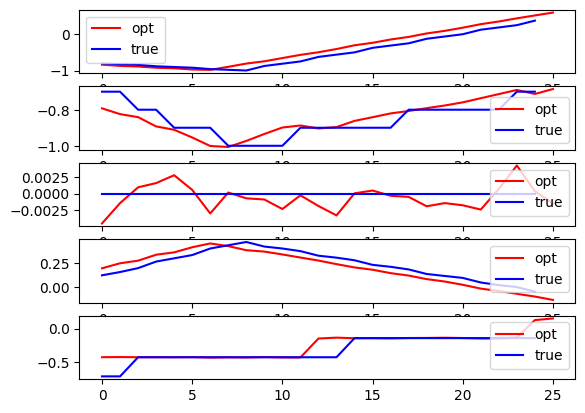

In [7]:
y = np.squeeze(np.array(out[0]))
ybar = data.values[timepoint:timepoint+step,env.output_index]
fig, ax = plt.subplots(5,1)

for i in range(5):
    ax[i].plot(y[:,i],'r',label='opt')
    ax[i].plot(ybar[:,i],'b',label='true')
    ax[i].legend()

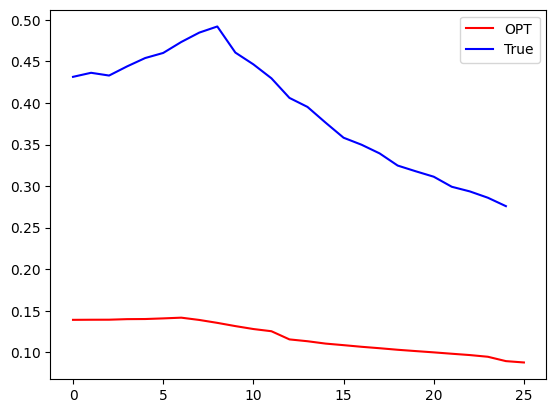

In [8]:
action_bar = data.values[timepoint:timepoint+step,env.title['control']]
output_bar = data.values[timepoint:timepoint+step,env.output_index]
r = []
for i in range(action_bar.shape[0]):
    r.append(ENV.reward(output_bar[i],action_bar[i]))

plt.plot(results['rewards'],'r',label='OPT')
plt.plot(r,'b',label='True')
plt.legend()